## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import date
import warnings;warnings.simplefilter('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Funciones

In [2]:
def adfuller_test(flujo):
    result = adfuller(flujo)
    labels = ['ADF Test Statistic','p-value','#Rezagos usados','Número de observaciones']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
      print("Se rechaza la hipótesis nula. La serie de tiempo es estacionaria")
    else:
      print("Poca evidencia en contra de la hipótesis nula. La serie de tiempo NO es estacionaria")

def evaluar_modelo(y_pred, y_true, model):

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    dataf = pd.DataFrame({
        "Modelo": model,
        "RMSE":[RMSE]
    })
    return dataf

def plot_modelo(train,test,pred) :
    fig, (ax1,ax2) = plt.subplots(2,figsize=(18,8))

    ax1.plot(train, label='Train')
    ax1.plot(test , label='Test')
    ax1.plot(pred, label='Forecast')
    ax1.legend(loc="upper right")

    ax2.plot(test, label='Test')
    ax2.plot(pred, label='Forecast')
    ax2.legend(loc="upper right")

    fig.suptitle("Train - Test - Forecast", fontsize=20) 


## Lectura de Datasets

Existe Otro archivo dentro del github que permite descargar automaticamente los datasets teniendo Firefox o Chrome:

In [3]:
Flujo_2017 = pd.read_csv(r"C:\Users\salve\OneDrive\Escritorio\SeriesDeTiempo\flujo-vehicular-2017.csv")
Flujo_2018 = pd.read_csv(r"C:\Users\salve\OneDrive\Escritorio\SeriesDeTiempo\flujo-vehicular-2018.csv")
Flujo_2019 = pd.read_csv(r"C:\Users\salve\OneDrive\Escritorio\SeriesDeTiempo\flujo-vehicular-2019.csv")

## Análisis exploratorio

In [4]:
Flujo_2017

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [5]:
#Se revisa que los tres datasets sean iguales en columnas y tipos

#Flujo_2017.info()
#Flujo_2018.info()
Flujo_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


In [6]:
# Unimos los 3 dataset y luego comenzamos el análisis exploratorio
FlujoTotal = pd.concat([Flujo_2017, Flujo_2018, Flujo_2019])

In [7]:
# Vemos los valores únicos por columna para darnos una mejor idea del DS
for i in FlujoTotal:
    print(FlujoTotal[i].unique())

[2017 2018 2019]
['2017-01-01' '2017-01-02' '2017-01-03' ... '2019-12-29' '2019-12-30'
 '2019-12-31']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]
['Domingo' 'Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento' 'Alberti' 'Dellepiane' 'PDB']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros' 'T. DISCAPACIDAD']
[  25    7    5 ... 3550 3266 3512]


In [8]:
FlujoTotal.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [9]:
#Realizamos un DS filtrado y sumando la cantidad de pasos por periodo para realizar un análisis macro

DatosGraficos = FlujoTotal.groupby(['periodo','estacion',	'sentido',	'tipo_vehiculo','forma_pago'])['cantidad_pasos'].sum()

In [10]:
DatosGraficos = pd.DataFrame(DatosGraficos).reset_index()

In [11]:
DatosGraficos

,periodo,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,Alberdi,Centro,Liviano,EFECTIVO,1410844
1,2017,Alberdi,Centro,Liviano,EXENTO,36358
2,2017,Alberdi,Centro,Liviano,INFRACCION,5546
3,2017,Alberdi,Centro,Liviano,NO COBRADO,25583
4,2017,Alberdi,Centro,Liviano,TARJETA DISCAPACIDAD,44834
...,...,...,...,...,...,...
355,2019,Salguero,Provincia,Pesado,TELEPASE,26304
356,2019,Sarmiento,Provincia,Liviano,NO COBRADO,307691
357,2019,Sarmiento,Provincia,Liviano,TELEPASE,932170
358,2019,Sarmiento,Provincia,Pesado,NO COBRADO,4534


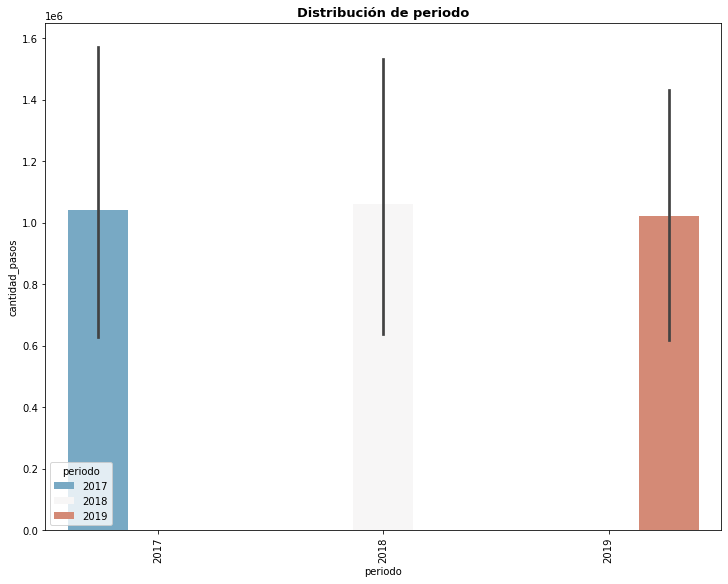

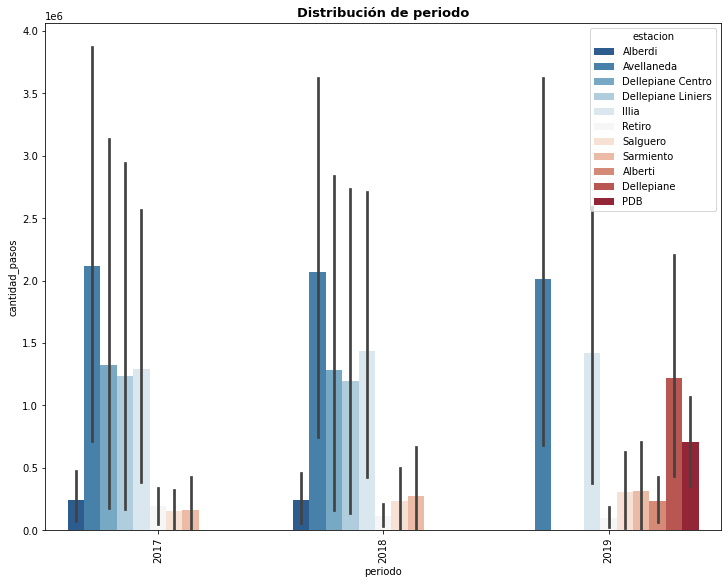

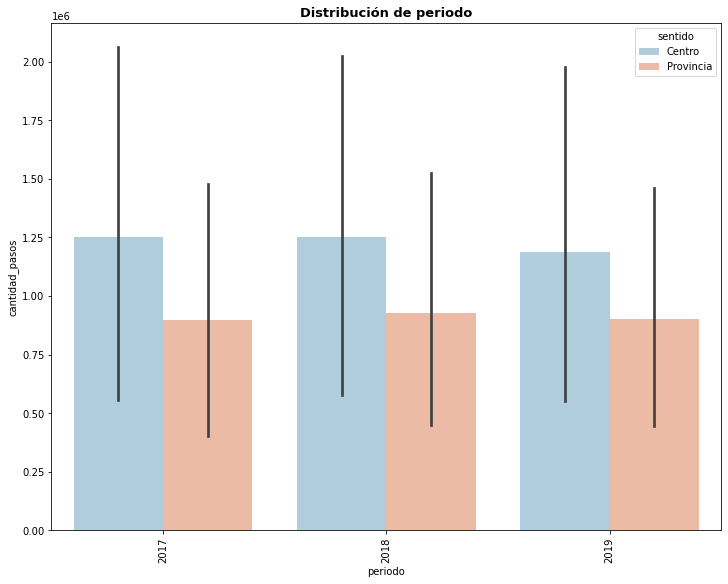

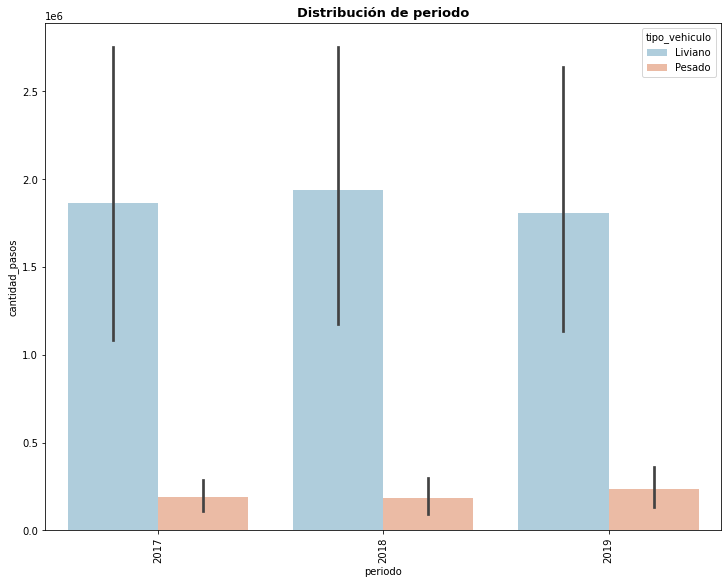

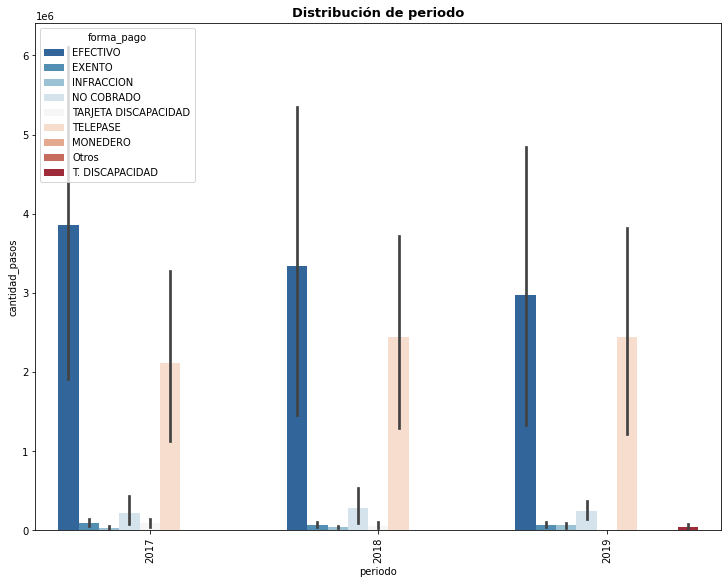

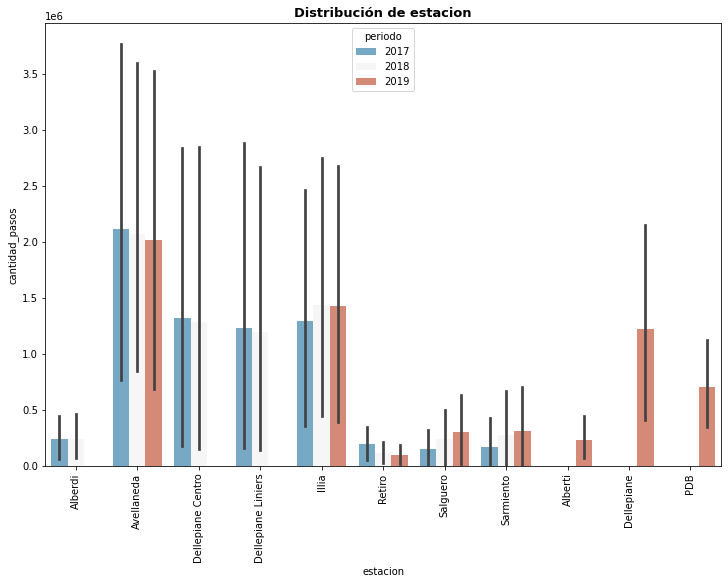

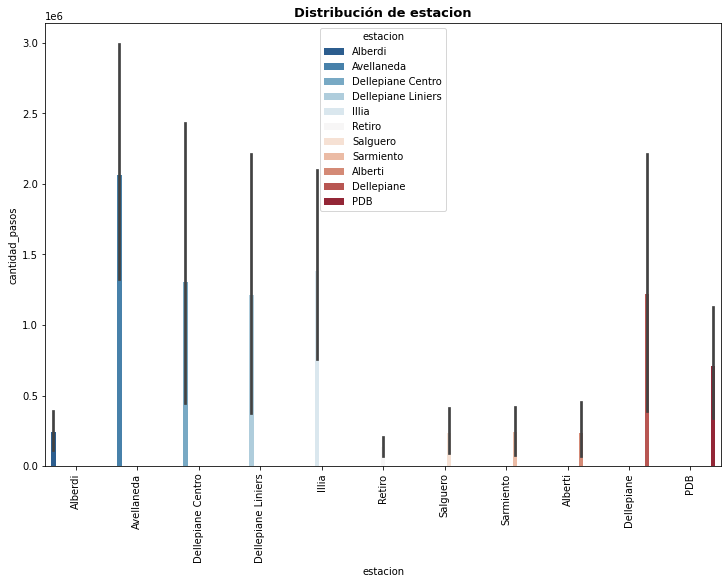

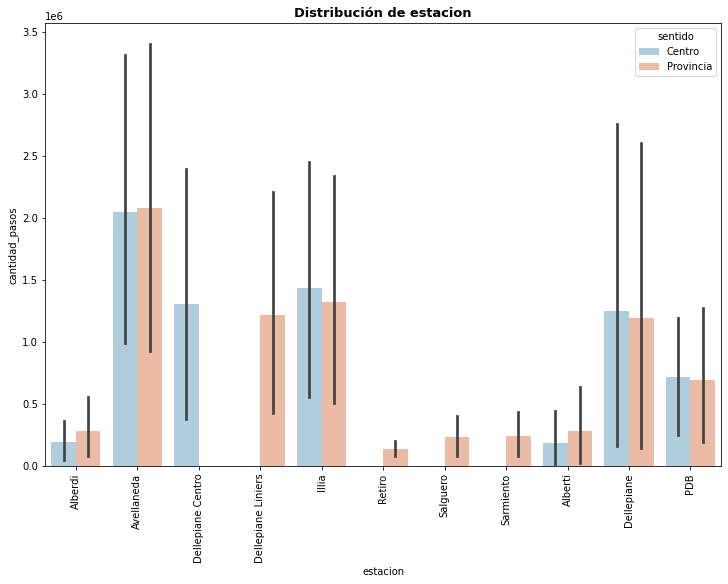

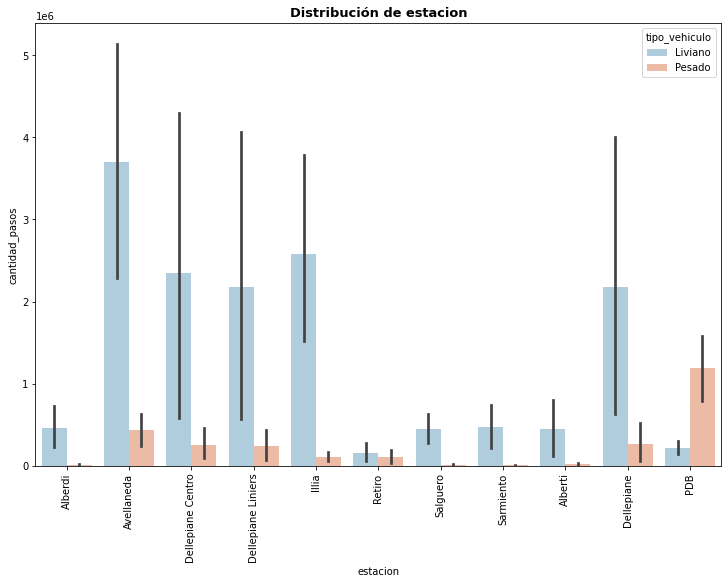

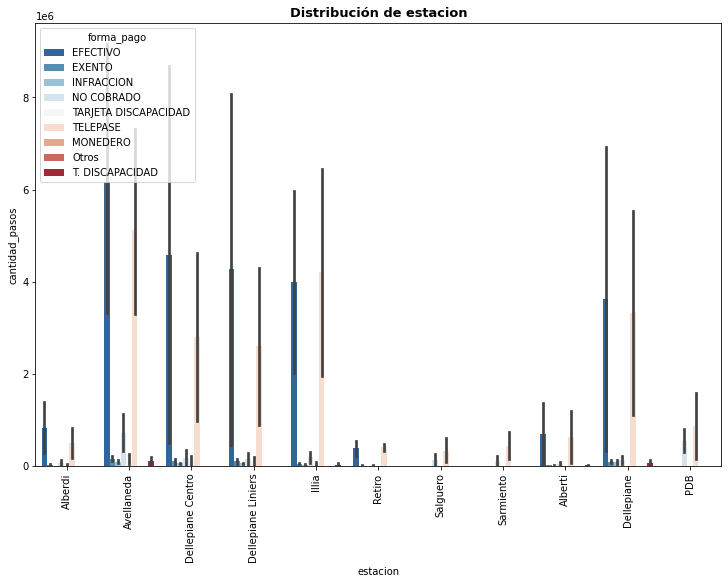

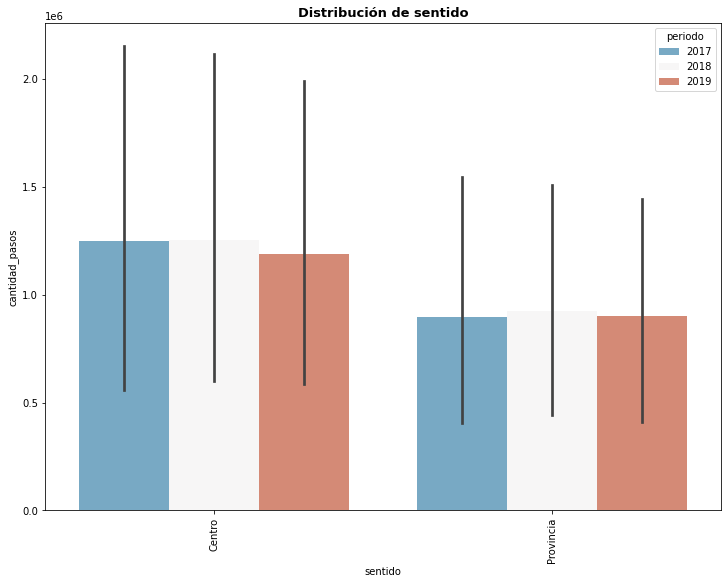

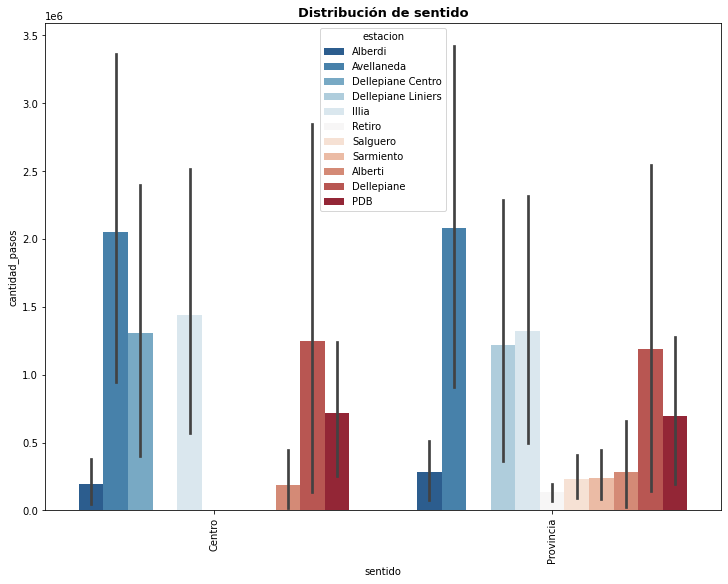

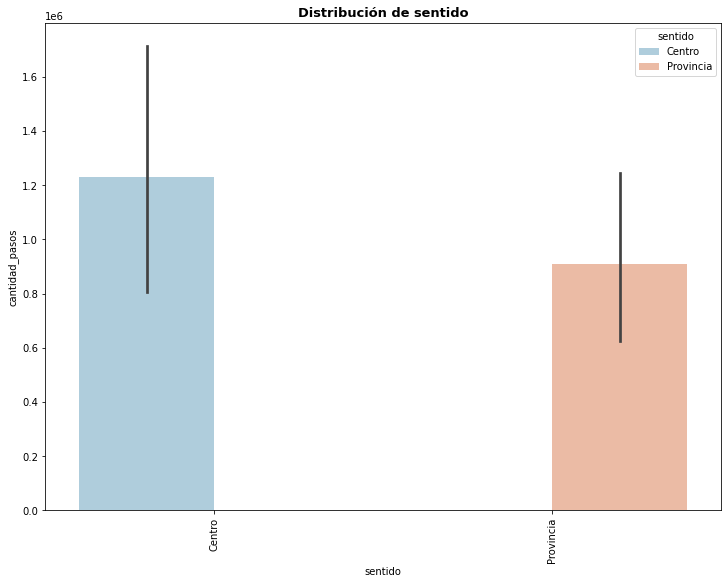

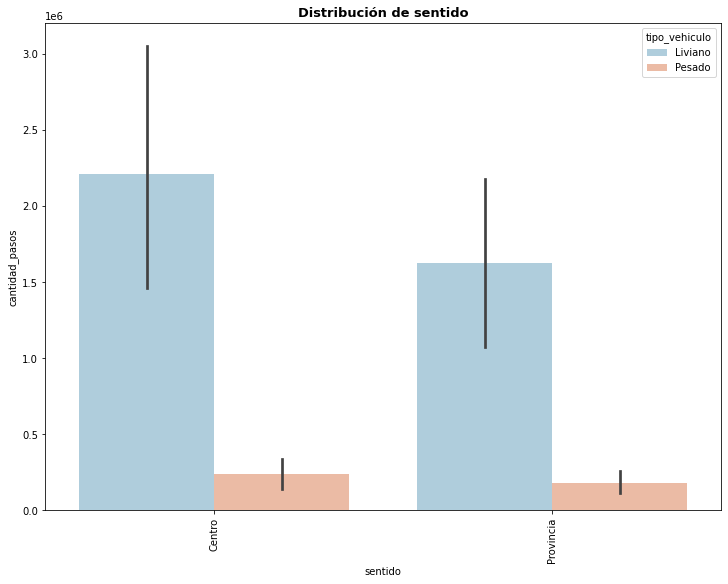

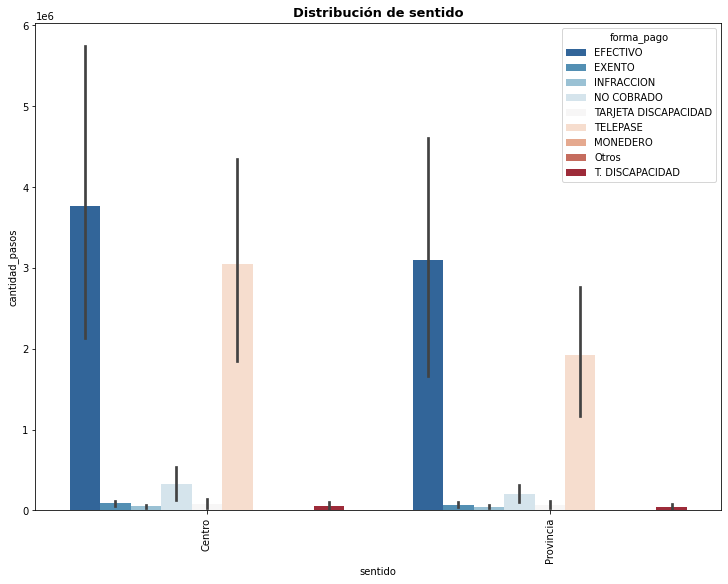

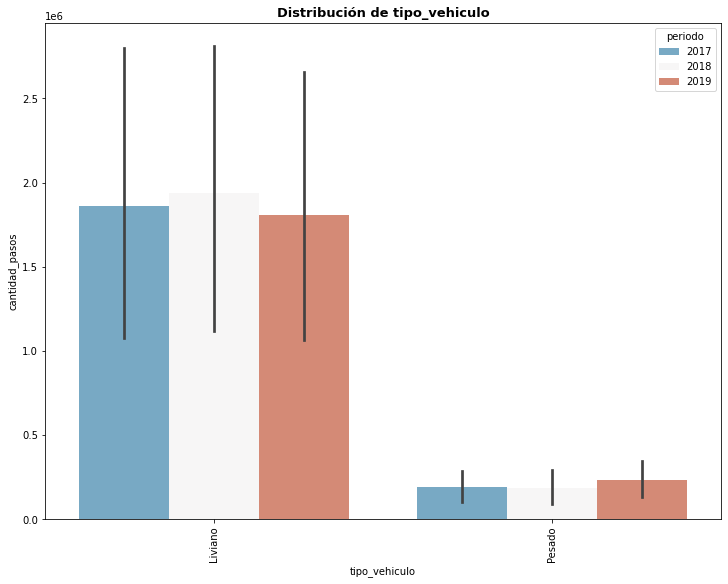

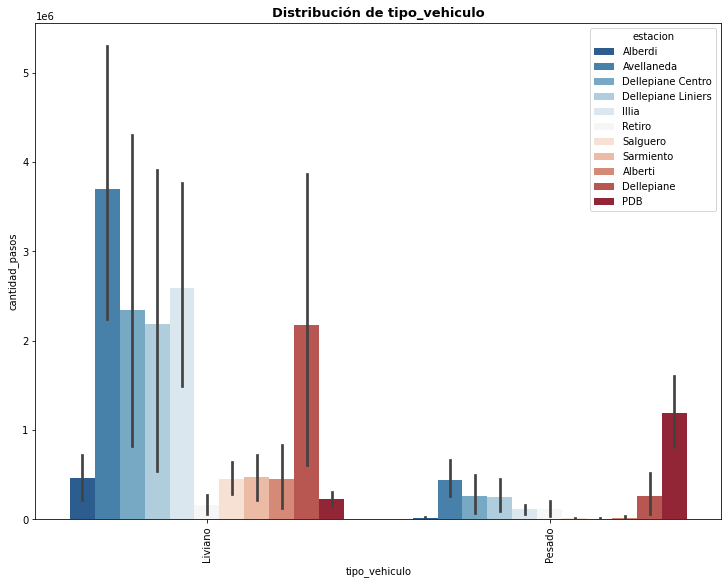

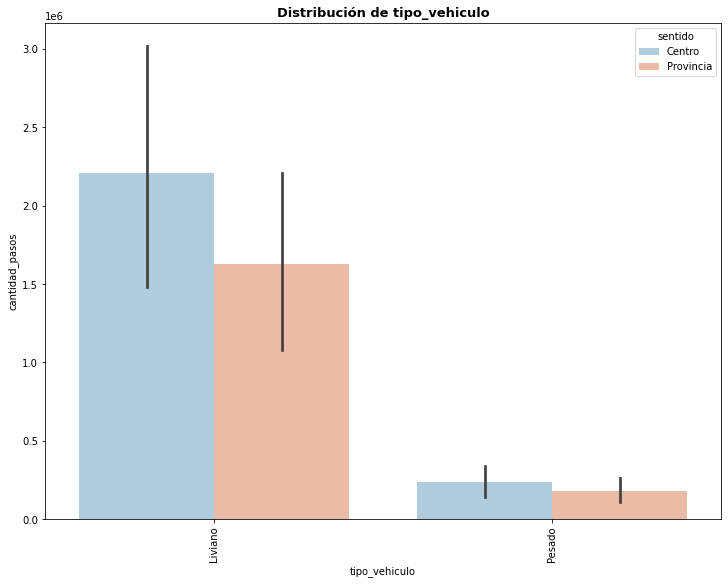

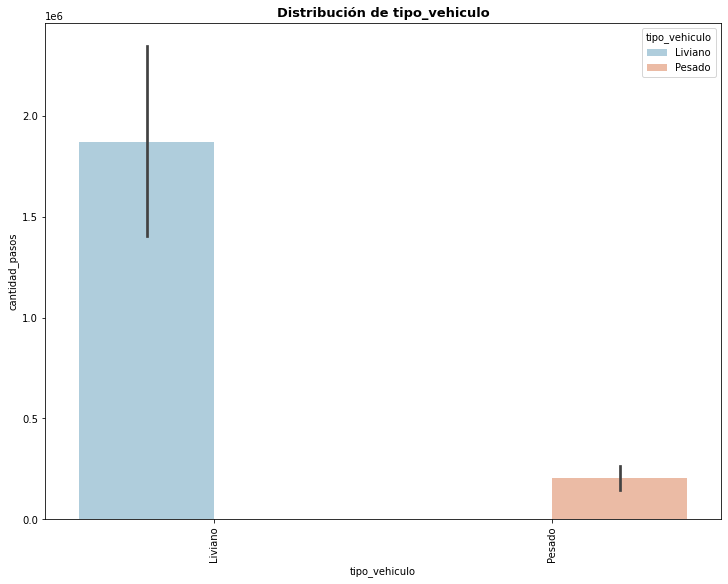

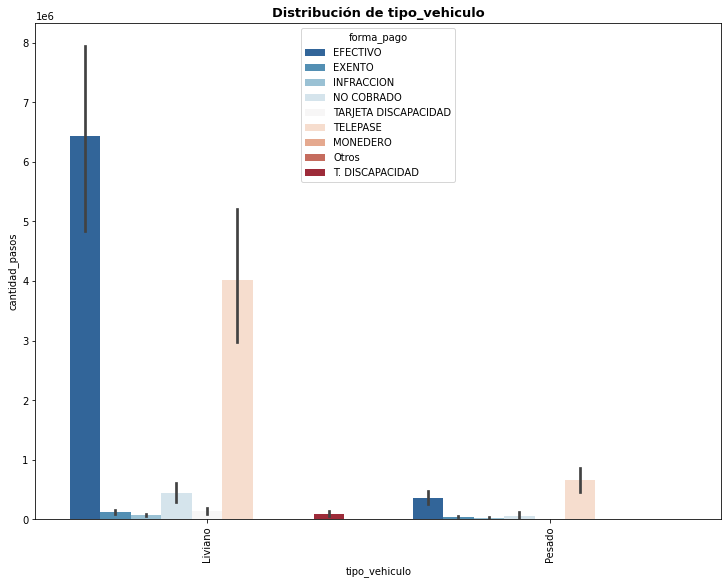

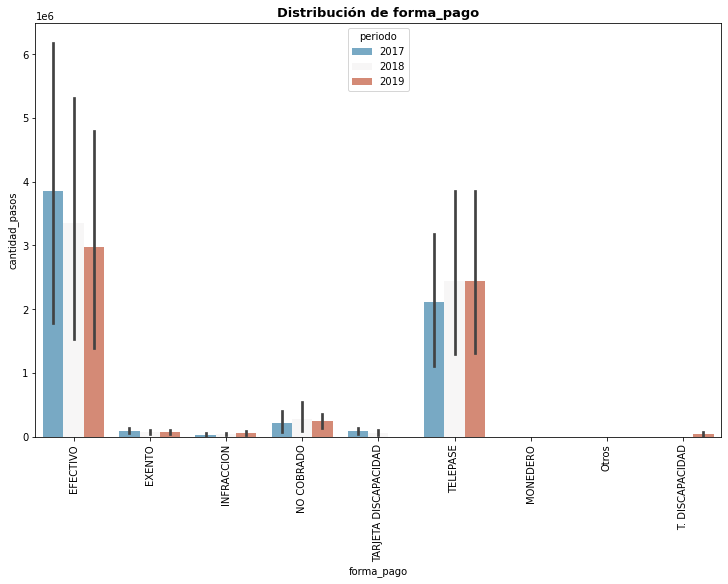

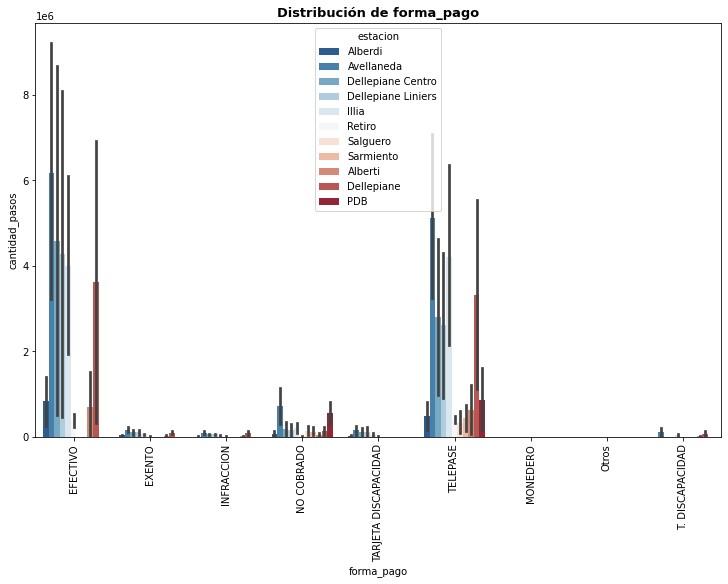

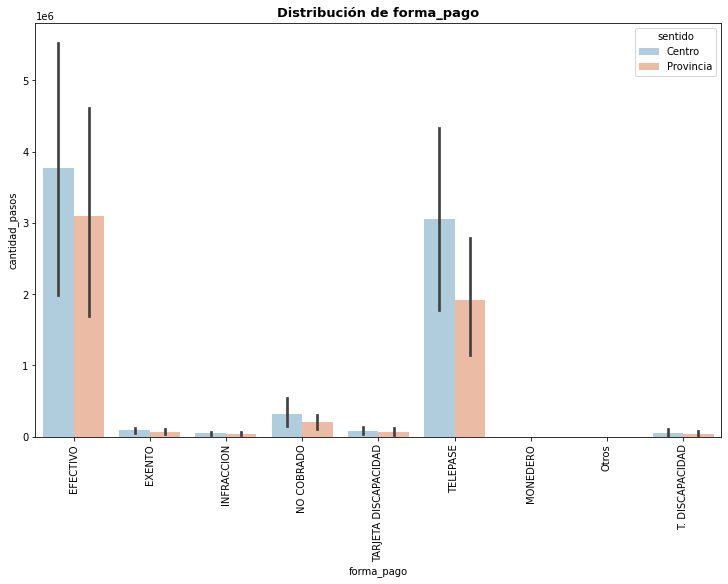

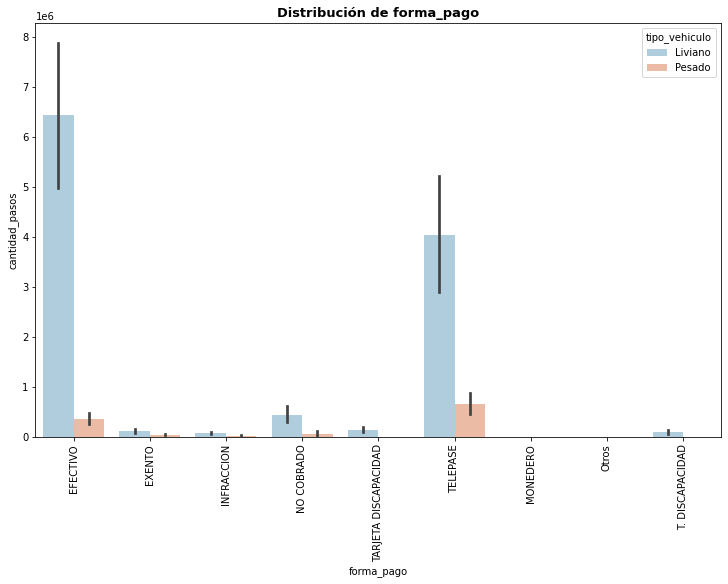

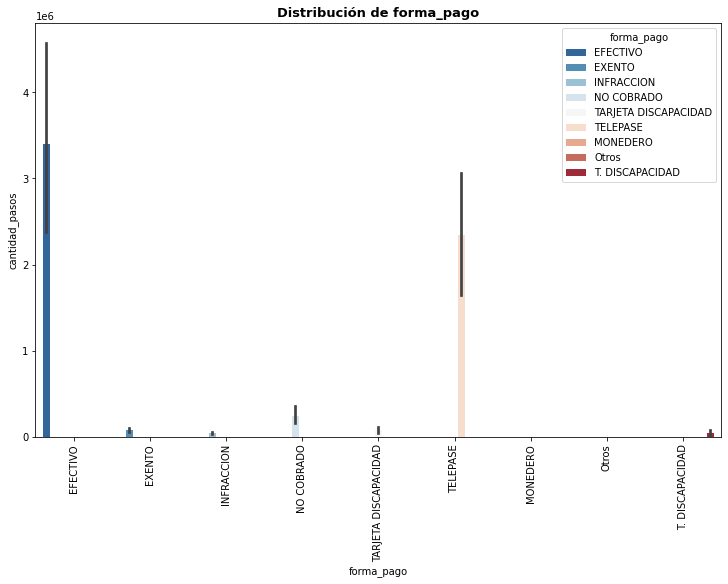

In [12]:
# Graficos sobre la distribución de las distintas columnas sumando la cantidad de pases
# Si bien existen gráficos redundantes o de no tanta utilidad, era más sencillo realizar un for anidado y luego elegir gráficos de utilidad

Columns = ['periodo','estacion','sentido','tipo_vehiculo','forma_pago']
Columns2 = ['periodo','estacion','sentido','tipo_vehiculo','forma_pago']
m = 0

for l in Columns2:
    for i in Columns:
        
        plt.figure(figsize = (10,8),
             constrained_layout=True)
        plt.subplot(1,(m+1),1)
        sns.barplot(data=DatosGraficos,
               x= l,
               y='cantidad_pasos',
               hue=i, 
               palette='RdBu_r')
        plt.title(f'Distribución de {l}', size=13, fontweight='bold')
        plt.xticks(rotation=90, size=10)
       


##### De los gráficos podemos sacar distintas conclusiones:
    - Los 3 años mantienen bastante estacionalidad aun que se puede advertir una leve caida en el 2019
    - Avellaneda es la estación con más cantidad de pasos anuales
    - El tráfico liviano es el de mayor tránsito
    - El tráfico liviano paga más en efectivo y el pesado más con telepase
    - En lo largo de estos 3 años ha disminuido el pago en efectivo y aumentado el pago con telepase
    

# Seleccion de datos

Para trabajar seleccionaremos los datos de la estación Avellaneda (la estación con mas pases) y tipo de vehiculo liviano.

Volveremos a traer el dataset en "crudo" y seleccionaremos los datos que correspondan

In [13]:
FlujoAve = FlujoTotal[(FlujoTotal['estacion'] == 'Avellaneda') & (FlujoTotal['tipo_vehiculo'] == 'Liviano')] # & (FlujoTotal['sentido'] == 'Centro')]
FlujoAve = FlujoAve.drop(columns=['hora_fin','estacion','sentido','tipo_vehiculo'])
FlujoAve

,periodo,fecha,hora_inicio,dia,forma_pago,cantidad_pasos
302,2017,2017-01-01,0,Domingo,NO COBRADO,507
303,2017,2017-01-01,0,Domingo,EFECTIVO,5
304,2017,2017-01-01,0,Domingo,TARJETA DISCAPACIDAD,1
305,2017,2017-01-01,0,Domingo,TELEPASE,115
307,2017,2017-01-01,1,Domingo,NO COBRADO,385
...,...,...,...,...,...,...
812057,2019,2019-12-31,22,Martes,TELEPASE,215
812113,2019,2019-12-31,23,Martes,NO COBRADO,289
812114,2019,2019-12-31,23,Martes,TELEPASE,53
812117,2019,2019-12-31,23,Martes,NO COBRADO,259


In [14]:
#Total de pases en todos los años
print(FlujoAve['cantidad_pasos'].sum())

133116697


In [15]:
FlujoAve.cantidad_pasos.describe()

# Mean : promedio de pases por HORA

count    406585.000000
mean        327.401889
std         611.572051
min           1.000000
25%           8.000000
50%          33.000000
75%         227.000000
max        6677.000000
Name: cantidad_pasos, dtype: float64

## Transformación de datos

In [16]:
# Calculo de los nulls
FlujoAve.isna().sum()

periodo           0
fecha             0
hora_inicio       0
dia               0
forma_pago        0
cantidad_pasos    0
dtype: int64

No existen valores faltantes en el dataset

In [17]:
# Cambio del tipo Object a datetime64 en la columna fecha
FlujoAve['fecha'] = pd.to_datetime(FlujoAve['fecha'])
# FlujoAve.info() # Verificamos que se haya realizado el cambio

### Reensample de los datos, agrupamos los pases por día:

In [18]:
# Paso diario de vehículos
FlujoAveDiario = FlujoAve
FlujoAveDiario['mes'] = FlujoAveDiario['fecha'].dt.month 
FlujoAveDiario = FlujoAve.groupby(['fecha', 'dia','mes','periodo'])['cantidad_pasos'].sum()
FlujoAveDiario = pd.DataFrame(FlujoAveDiario)
FlujoAveDiario = FlujoAveDiario.reset_index()
FlujoAveDiario


,fecha,dia,mes,periodo,cantidad_pasos
0,2017-01-01,Domingo,1,2017,97547
1,2017-01-02,Lunes,1,2017,124042
2,2017-01-03,Martes,1,2017,123360
3,2017-01-04,Miércoles,1,2017,126710
4,2017-01-05,Jueves,1,2017,130987
...,...,...,...,...,...
1090,2019-12-27,Viernes,12,2019,137887
1091,2019-12-28,Sábado,12,2019,101878
1092,2019-12-29,Domingo,12,2019,81086
1093,2019-12-30,Lunes,12,2019,115308


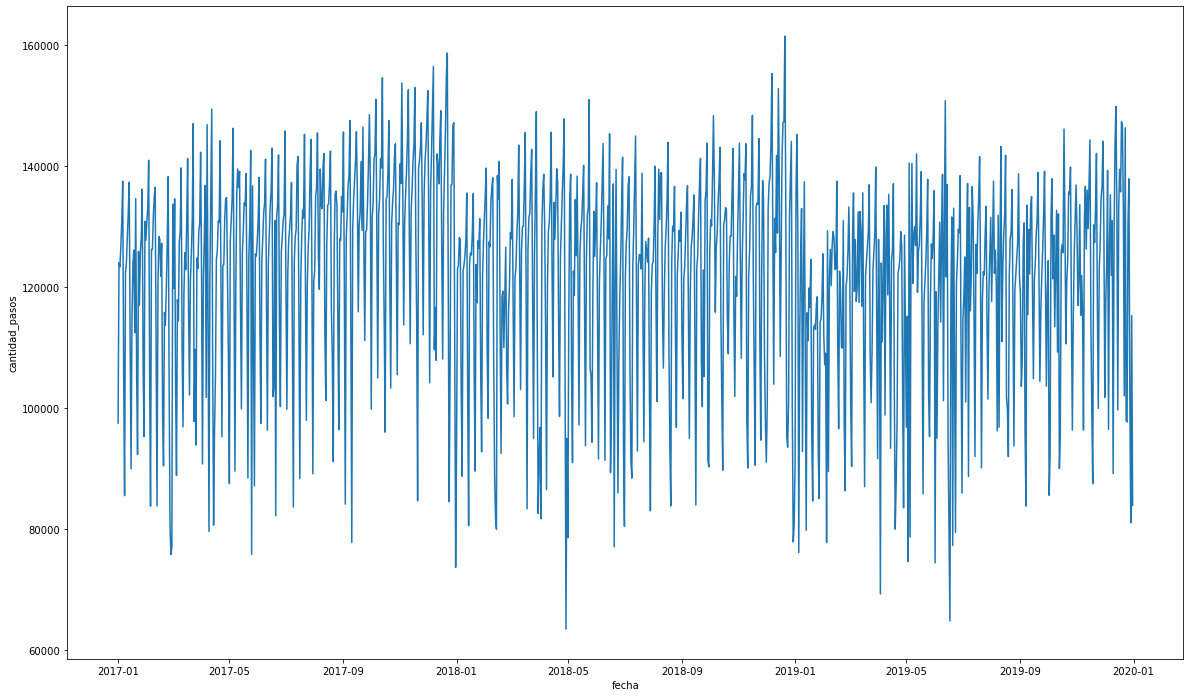

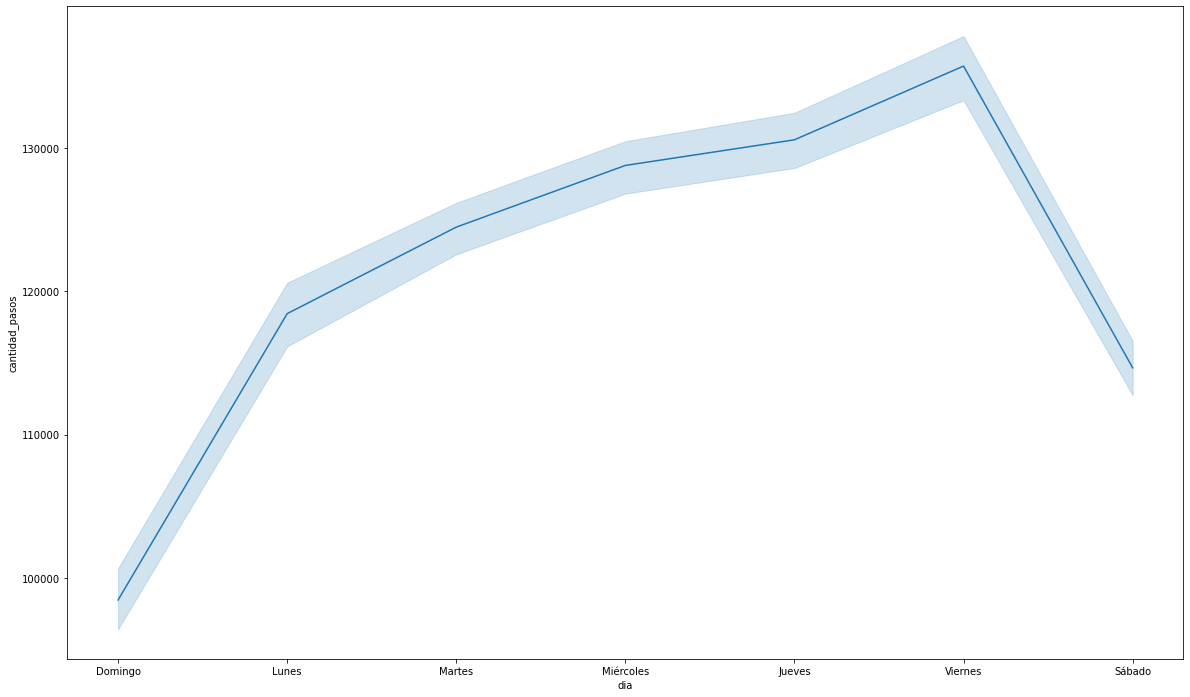

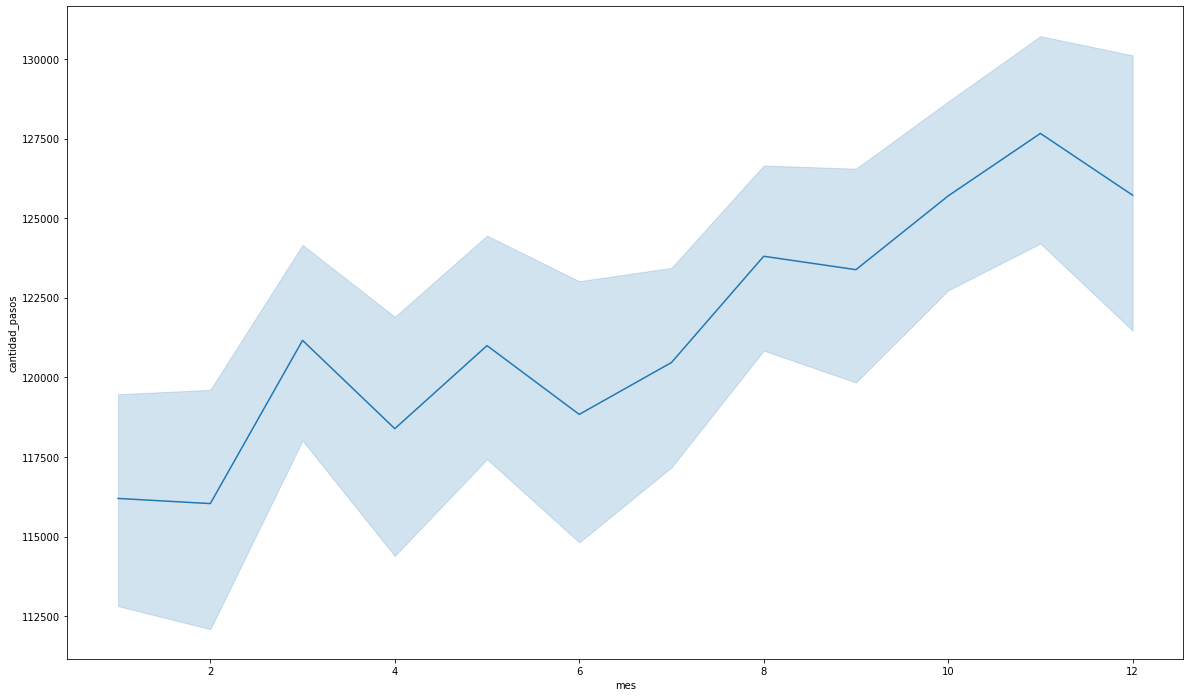

In [19]:
fechas = ['fecha', 'dia','mes']

for i in fechas:
    plt.figure(figsize = (20,12))
    sns.lineplot(data = FlujoAveDiario,
            x = i, 
            y = 'cantidad_pasos',
            sort=False,
            )

Con estos gráficos bien podemos ver:

Que existe una estacionalidad semanal, donde de lunes a viernes es cúando más vehículos pasan por el peaje.
Que los meses 1 y 2 son los meses con menor pase, probablemene se deba a las vacaciones de verano, y luego durante el año se mantiene una tendencia alcista (aunque el gráfico es engañoso y no hay una diferencia realmente muy grande).

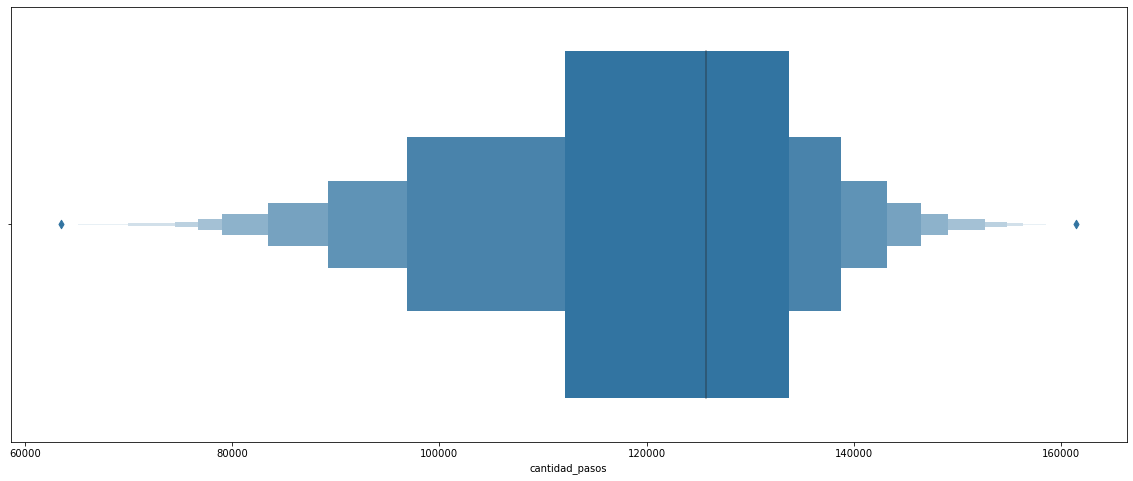

In [20]:

    plt.figure(figsize = (20,8))
    sns.boxenplot(FlujoAveDiario.cantidad_pasos)

In [21]:
FlujoAveDiario[(FlujoAveDiario['cantidad_pasos'] <70000 ) | (FlujoAveDiario['cantidad_pasos'] > 158000 ) ]

,fecha,dia,mes,periodo,cantidad_pasos
355,2017-12-22,Viernes,12,2017,158673
483,2018-04-29,Domingo,4,2018,63504
719,2018-12-21,Viernes,12,2018,161455
822,2019-04-03,Miércoles,4,2019,69313
897,2019-06-17,Lunes,6,2019,64839


Con el gráfico y tabla anterior podemos ver que no existen Outiliers relevantes e investigando en internet no se encuentran motivos de la suba o minimazación de pases de la tabla anterior. Por lo cual se dejan dentro del dataset

In [22]:
#pasamos la columna día de categorica a cuantitativa

FlujoAveDiario = FlujoAveDiario.drop(columns=['dia'])
FlujoAveDiario['dia'] = FlujoAveDiario['fecha'].dt.dayofweek

In [23]:
# Se agrega una columna con las fechas en formato numerico para poder hacer la regresion lineal
FlujoAveDiario['fecha_numeros'] = FlujoAveDiario['fecha'].map(datetime.toordinal)
FlujoAveDiario.head()

,fecha,mes,periodo,cantidad_pasos,dia,fecha_numeros
0,2017-01-01,1,2017,97547,6,736330
1,2017-01-02,1,2017,124042,0,736331
2,2017-01-03,1,2017,123360,1,736332
3,2017-01-04,1,2017,126710,2,736333
4,2017-01-05,1,2017,130987,3,736334


In [24]:
diario = FlujoAveDiario.resample('D', on = 'fecha').sum()
diario = diario.cantidad_pasos
diario = pd.DataFrame(diario)


<Figure size 1440x576 with 0 Axes>

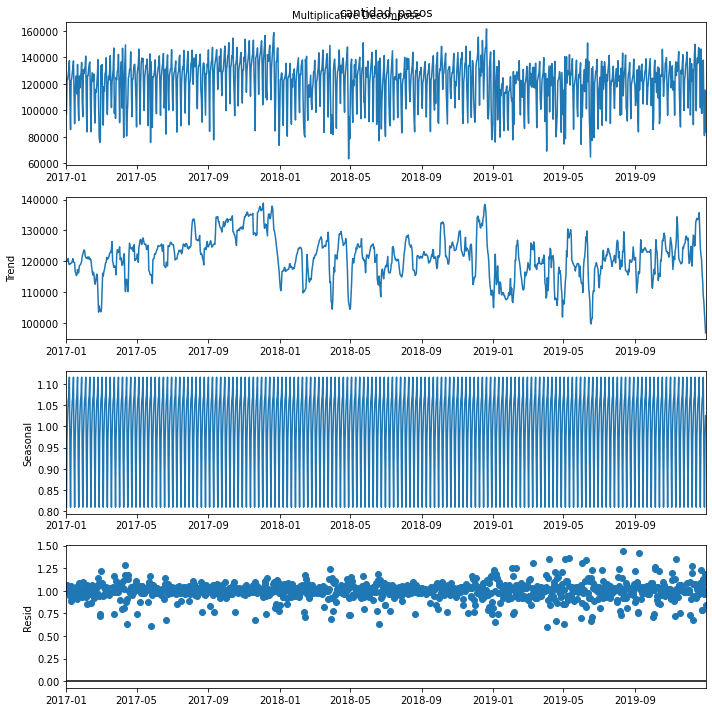

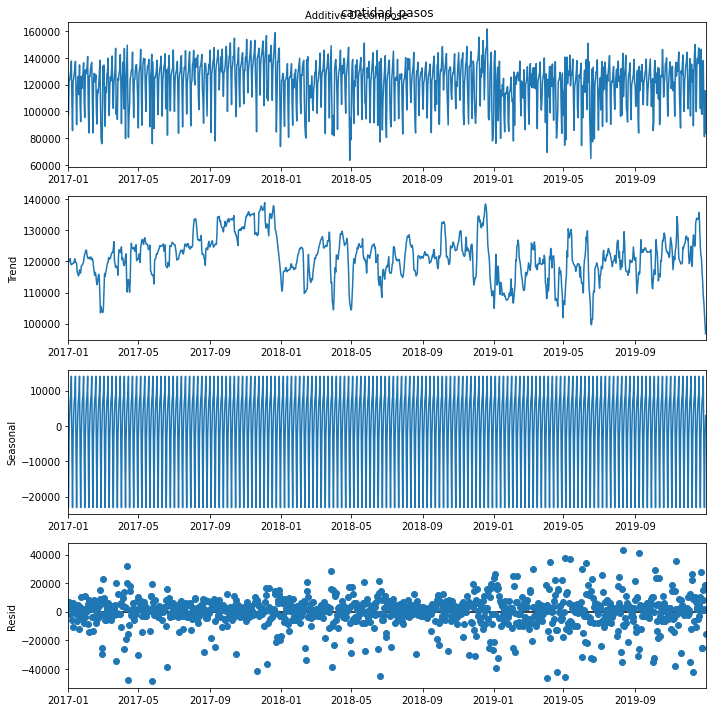

In [25]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(diario['cantidad_pasos'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(diario['cantidad_pasos'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
plt.figure(figsize = (20,8))
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

In [26]:
# Generamos la media movil para luego utilizarla en gráfico
media_movil = diario.rolling(
    window=365,
    center=True,
    min_periods= 183
).mean()

In [63]:
# definimos la regresión lineal y la entrenamos
lr = LinearRegression()
lr.fit(FlujoAveDiario.fecha_numeros.values.reshape(-1, 1), FlujoAveDiario.cantidad_pasos)

LinearRegression()

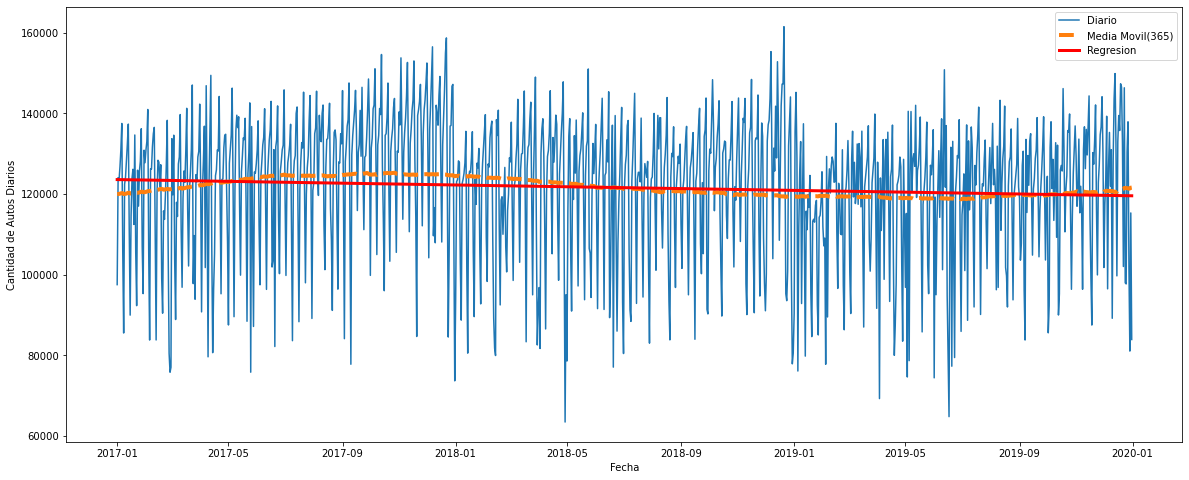

In [28]:
plt.figure(figsize = (20,8))
plt.plot(FlujoAveDiario.fecha, FlujoAveDiario.cantidad_pasos, label = 'Diario')
plt.plot(media_movil, ls = '--', lw = 4, label = 'Media Movil(365)')
plt.plot(FlujoAveDiario.fecha, lr.predict(FlujoAveDiario.fecha_numeros.values.reshape(-1, 1)), linewidth = 3, color = 'red', label = 'Regresion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos Diarios')
plt.legend()
plt.show()

Si bien la media movil nos muestra como puede moverse a grandes rasgos la curva original no es suficientemente buena para sacar conclusiones.
La regresión lineal es un modelo demasiado simplista y no nos ayuda a conocer realmente como serán los pases, aun que muestra una ligera tendencia negativa

# MODELOS

## Bechmark: ARIMA

EStá compuesto por:
AR (p) como una regresion lineal de los p valores anteriores a t
MA (q) como una regresion lineal de los q términos de error anteriores a t
por ultimo la resta de los dos componentes pero calculados para Yt-d y volverla estacionaria

Realizamos la priba de Dicket-fuller para saber si la serie es estacionaria

In [29]:
adfuller_test(FlujoAveDiario.cantidad_pasos)

ADF Test Statistic : -4.574838717077473
p-value : 0.00014368892910325294
#Rezagos usados : 22
Número de observaciones : 1072
Se rechaza la hipótesis nula. La serie de tiempo es estacionaria


In [30]:
#FlujoAveDiario2 = FlujoAveDiario.set_index("fecha")

In [31]:
# a = seasonal_decompose(FlujoAveDiario2.cantidad_pasos)
# a.plot()

Parametro "p" - AR

<Figure size 1800x600 with 0 Axes>

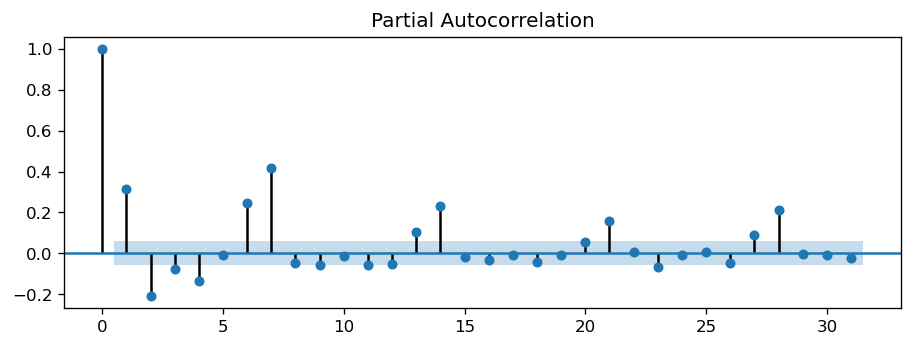

In [32]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.figure(figsize = (15,5))
plot_pacf(FlujoAveDiario.cantidad_pasos)
plt.show()

Definimos que p = 7

Parametro "q" - MA

<Figure size 1800x600 with 0 Axes>

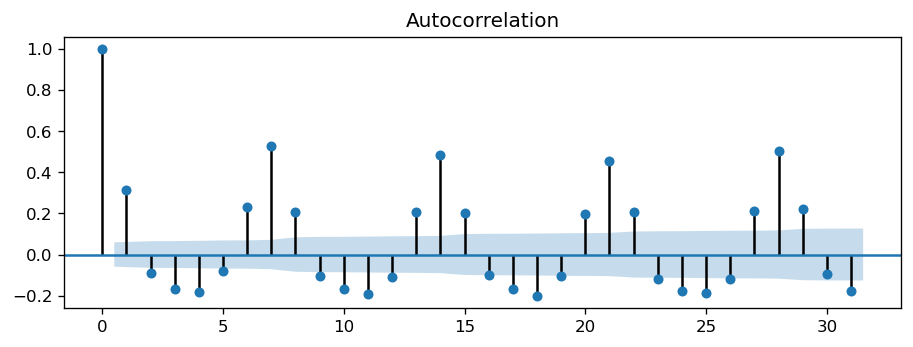

In [33]:
plt.figure(figsize = (15,5))
plot_acf(FlujoAveDiario.cantidad_pasos)
plt.show()

Definimos que q = 7

In [34]:
model_arima = ARIMA(FlujoAveDiario.cantidad_pasos, order=(4,0,7))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                              ARMA Model Results                              
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                     ARMA(4, 7)   Log Likelihood              -11912.022
Method:                       css-mle   S.D. of innovations          12760.067
Date:                Mon, 25 Jul 2022   AIC                          23850.045
Time:                        22:39:03   BIC                          23915.025
Sample:                             0   HQIC                         23874.633
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.216e+05    539.986    225.131      0.000    1.21e+05    1.23e+05
ar.L1.cantidad_pasos     0.8031      0.001    891.193      0.000       0.801       0.805
ar.L2.cantid

Obtenemos un AIC = 23784.081

In [35]:
FlujoAveDiario.set_index('fecha', inplace=True)

In [36]:
train_diario = FlujoAveDiario.loc[(FlujoAveDiario.index < '2019-7-01')]
test_diario = FlujoAveDiario.loc[(FlujoAveDiario.index >= '2019-7-01')]

In [37]:
fc, se, conf = model_arima_fit.forecast(184, alpha=0.05)

In [38]:
res_bench =  evaluar_modelo(fc, test_diario.cantidad_pasos, "Benchmark(diario)")

In [39]:
predicciones_diario = pd.Series(data=fc, index=test_diario.cantidad_pasos.index)

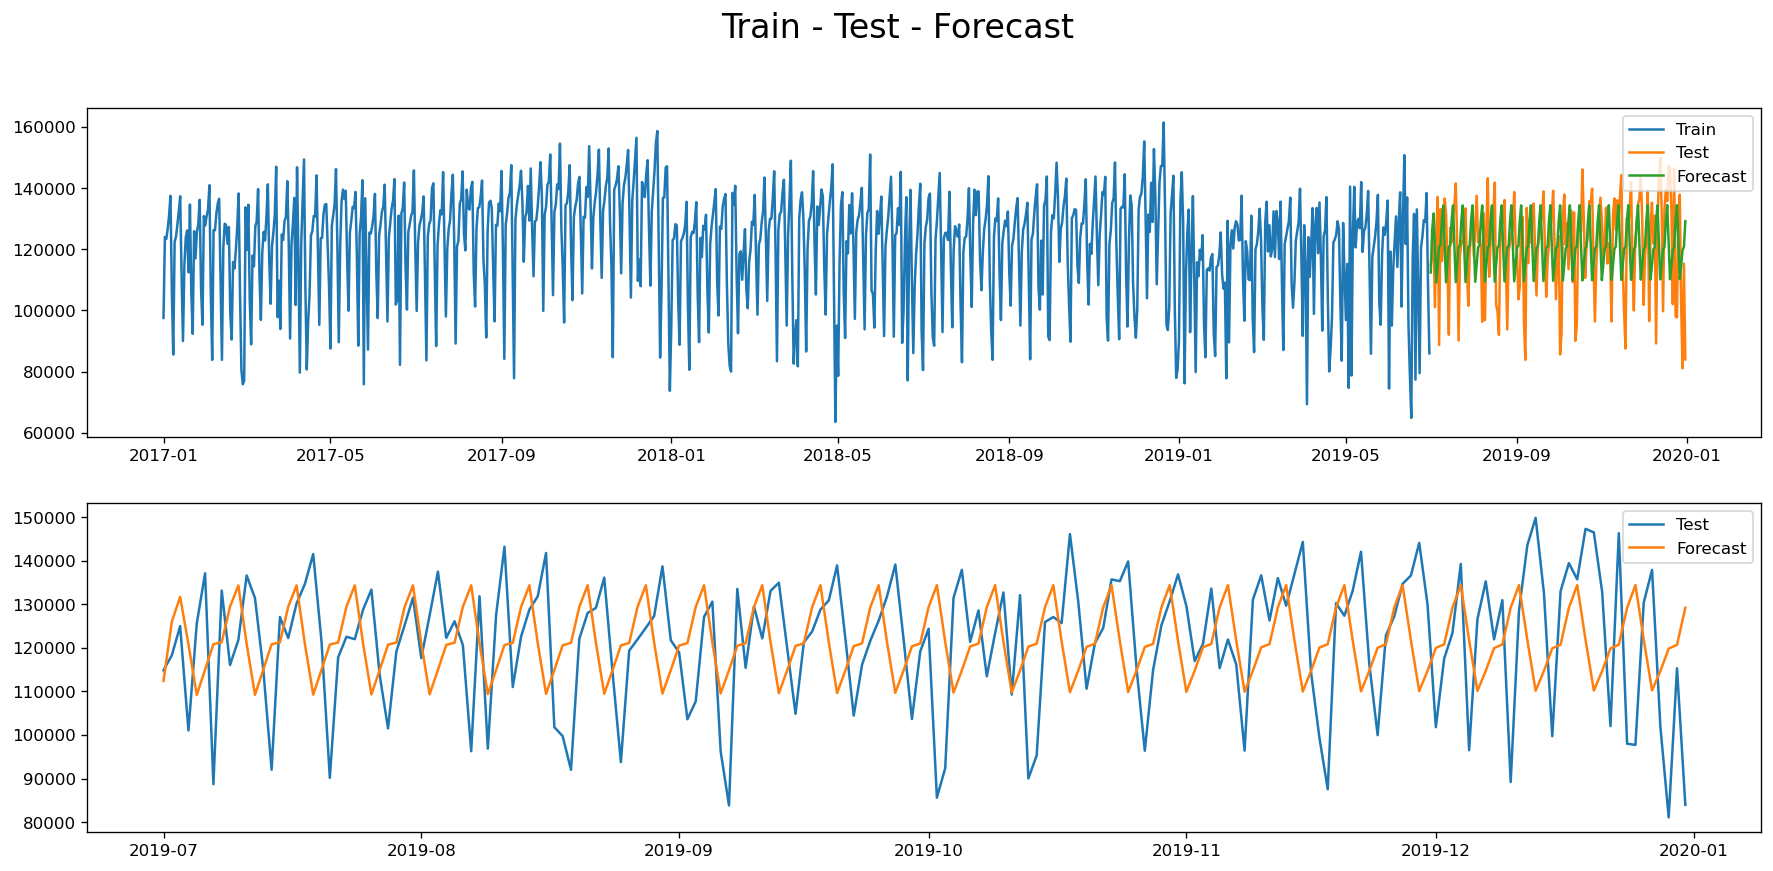

In [40]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_diario)

In [41]:
arima_diario_res = evaluar_modelo(predicciones_diario, test_diario.cantidad_pasos, "Arima Diario")
arima_diario_res

,Modelo,RMSE
0,Arima Diario,17753.052024


In [42]:
# import statsmodels.api as sm
# sm.stats.acorr_ljungbox(model_arima_fit.resid, lags=[10],return_df=True)

## Autoarima

In [43]:
modelAA_diario = auto_arima(FlujoAveDiario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)
print(modelAA_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24419.243, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24816.134, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24775.885, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24508.313, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24814.134, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24366.636, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24680.974, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24363.721, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24645.728, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24304.051, Time=0.60 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=24573.186, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24217.121, Time=0.60 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=24386.370, Time=0.40 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=24104.375, Time=1.41 sec
 ARIMA(6,1,0)(0,0,0

Best model:  ARIMA(6,1,1)(0,0,1)[7] 

In [44]:
modelAA_diario.fit(train_diario.cantidad_pasos)
pred_AA_diario = modelAA_diario.predict(n_periods=184, return_conf_int=False)
predicciones_AA_diario = pd.Series(data=pred_AA_diario, index=test_diario.cantidad_pasos.index)
predicciones_AA_diario.head()

fecha
2019-07-01    111067.118740
2019-07-02    123085.603145
2019-07-03    123365.452721
2019-07-04    126396.047326
2019-07-05    127554.584664
dtype: float64

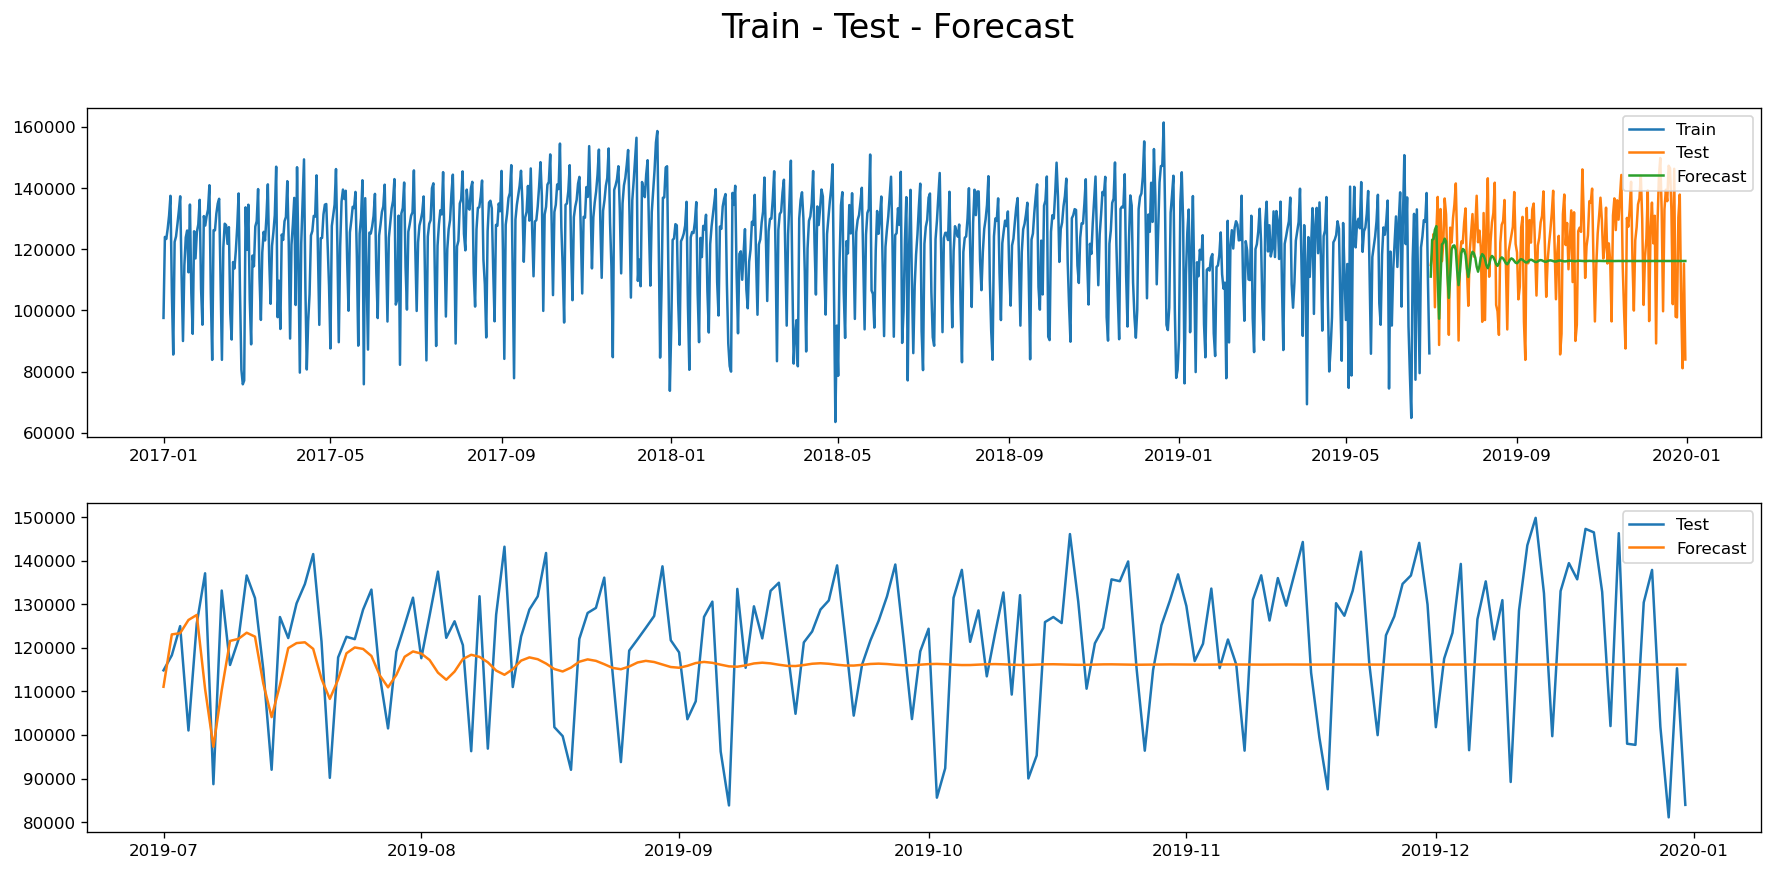

In [45]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AA_diario)

In [46]:
autoarima_diario_res = evaluar_modelo(predicciones_AA_diario, test_diario.cantidad_pasos, "AutoArima Diario")
autoarima_diario_res


,Modelo,RMSE
0,AutoArima Diario,15904.085589


## Autoriarima con mejora de hiperparametros

Se agrega 'm' que mejora muchísimo la estacionalidad del modelo y se bajan los valores max de p y q para optimizacion

In [47]:
modelAAHP_diario = auto_arima(FlujoAveDiario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=6, max_q=6,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0,
                      m=7,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)
print(modelAAHP_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=24295.078, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=24816.134, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=24512.019, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=24367.022, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=24814.134, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=24419.243, Time=0.64 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=24610.051, Time=0.23 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=24276.251, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=24366.636, Time=0.72 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=24229.0

In [48]:
modelAAHP_diario.fit(train_diario.cantidad_pasos)
pred_AAHP_diario = modelAAHP_diario.predict(n_periods=184, return_conf_int=False)
pred_AAHP_diario = pd.Series(data=pred_AAHP_diario, index=test_diario.cantidad_pasos.index)
pred_AAHP_diario.head()

fecha
2019-07-01    107143.993167
2019-07-02    122531.029863
2019-07-03    124437.307619
2019-07-04    122285.684391
2019-07-05    126281.009260
dtype: float64

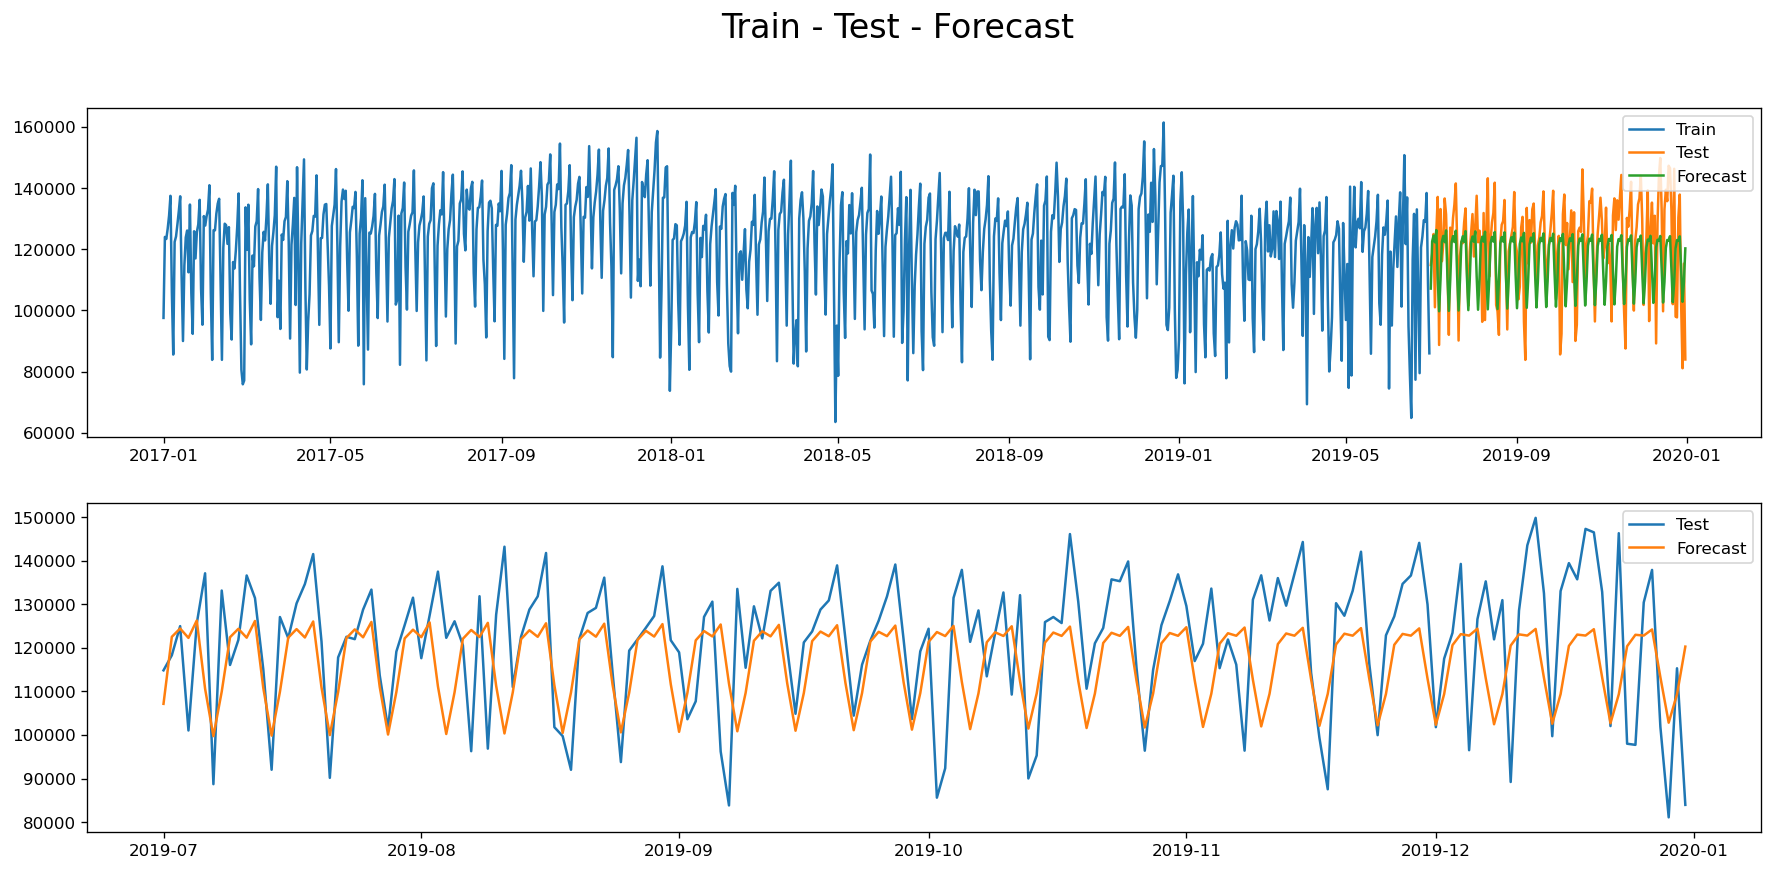

In [49]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, pred_AAHP_diario)

In [68]:
autoarima_diario_HP = evaluar_modelo(pred_AAHP_diario, test_diario.cantidad_pasos, "AutoArima HP Diario")
autoarima_diario_HP


,Modelo,RMSE
0,AutoArima HP Diario,14883.973631


## Prophet

In [51]:
prophet_diario = pd.DataFrame({'ds':pd.to_datetime(train_diario.index), 'y':train_diario.cantidad_pasos})
prophet_diario['ds'] = pd.to_datetime(prophet_diario['ds'], format='%Y-%m-%d')

In [52]:
prophet_fore = prophet_diario

In [53]:
prophet_fore = prophet_fore.reset_index()
prophet_fore = prophet_fore.drop(['fecha'], axis=1)

In [54]:
prophet_diario_model = Prophet(daily_seasonality=True)


In [55]:
prophet_diario_model.fit(prophet_fore)


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [56]:
pred_prophet = prophet_diario_model.make_future_dataframe(periods=184, freq="D")
forecast = prophet_diario_model.predict(pred_prophet)

In [57]:
prophet_test_diario = pd.DataFrame({'ds':pd.to_datetime(test_diario.index), 'y':test_diario.cantidad_pasos})
prophet_test_diario['ds'] = pd.to_datetime(prophet_test_diario['ds'], format='%Y-%m-%d')
prophet_test_diario = prophet_test_diario.reset_index()
prophet_test_diario = prophet_test_diario.drop(['fecha'], axis=1)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

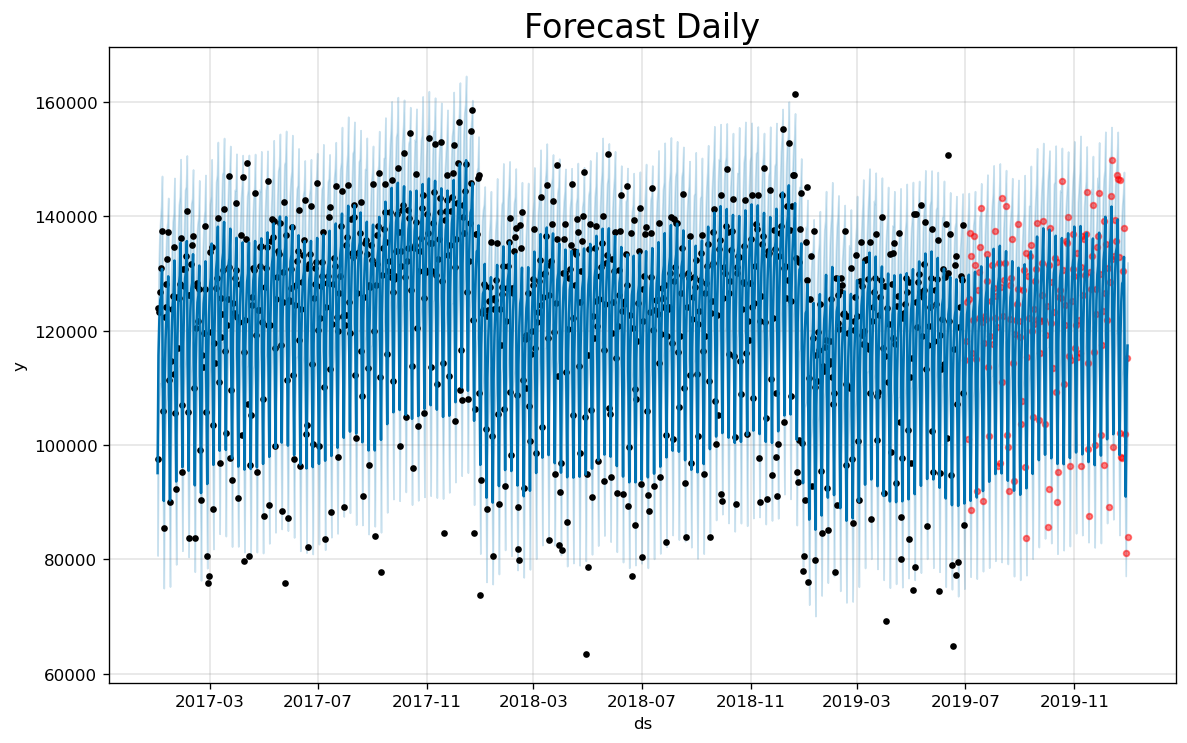

In [58]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(prophet_test_diario.ds, prophet_test_diario.y, color= "red", s=12 ,alpha=0.5)
plt.title('Forecast Daily', fontsize=20)

In [59]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >='2019-7-01')]
y_true = prophet_test_diario[['ds', 'y']]

res_prophet_diario = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")
res_prophet_diario

,Modelo,RMSE
0,Prophet Diario,14534.419431


Los modelos utilizan las fechas y la cantidad de pases diarios para realizar su predicción, si se los enfoca con buenos hiperparametros o el modelo es robusto de por sí (como es el caso de Prophet) se obtienen buenos resultados.

Resultado de los modelos

Creo que en estos modelos no sólo hay que fijarse cúan bueno ha sido su RMSE, sino también revisar como se comporta la curva de predicción debido a que esta es una variable muy importante porque podemos lograr un buen RMSE con una linea recta (como una regresión) pero lo importante es poder predecir el comportamiento.

In [69]:
RESULTADOS = pd.concat([res_prophet_diario, 
                        autoarima_diario_HP,
                        autoarima_diario_res,
                        arima_diario_res])
RESULTADOS.reset_index(drop=True)

,Modelo,RMSE
0,Prophet Diario,14534.419431
1,AutoArima HP Diario,14883.973631
2,AutoArima Diario,15904.085589
3,Arima Diario,17753.052024


Como mejor modelo elegiré el "AutoArima HP Diario" ya que si bien tiene un RMSE un poco más alto que el modelo Prophet, el modelo ha logrado copiar la tendencia de una forma muy similar a la realidad (el gráfico es claro en eso) aunque un poco corrido.

## Investigación

j.

En las preguntas que podemos ahondar serían:

    1- Como ha variado la forma de pago a lo largo de estos años?
    2- Cuál es su tendencia?
    3- Predecir con alguno de los modelos utilizados como serán las curvas de pago en efectivo y por telepase para la optimización del peaje.

K.

El flujo de trabajo sería un estudio similar al que se realizó en este trabajo,
Se dividiría el dataset entre las distintas formas de pago para ver su comportamiento por separado y se realizarían los modelos.
Con ello se podría estimar como crece o decrese el pago el efectivo y telepase y tomar decisiones respecto a la cantidad de personal que atienda